In [9]:
import os
import numpy as np
import pydicom
import tensorflow as tf
from skimage.transform import resize
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras import layers, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
#from keras.src import layers


from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img

In [10]:



# Set base paths
image_path_base = '/Users/elianafreedman/Desktop/cropped cmmd/CMMD png'
text_path_base = '/Users/elianafreedman/Desktop/cropped cmmd/cleanCropCMMD.csv'

def get_image_paths_and_labels():
    image_paths = []
    labels = []
    b_count = 0
    M_count = 0

    with open(text_path_base) as f:
        f.readline()  # Skip header

        for line in f:
            splitLine = line.split(",")

            imagePath = splitLine[2].replace("\n", "").replace('"', "")
            imagePath = imagePath.replace('C:\\ML Data\\Chinesearchive\\TheChineseMammographyDatabase\\CMMD png 2\\', image_path_base + '/')
            full_image_path = os.path.join(image_path_base, imagePath.strip())

            image_paths.append(full_image_path)

            classification = splitLine[1].replace('"', '').strip()
            if classification == "0":
                labels.append(np.array([0]))
                b_count += 1
            elif classification == "1":
                labels.append(np.array([1]))
                M_count += 1

    print(f"Benign count: {b_count}")
    print(f"Malignant count: {M_count}")
    return np.array(image_paths), np.array(labels)

# original image paths and labels
image_paths, labels = get_image_paths_and_labels()

# separate benign and malignant paths
benign_paths = image_paths[labels.flatten() == 0]
malignant_paths = image_paths[labels.flatten() == 1]

# B\balance the dataset
num_to_augment = len(malignant_paths) - len(benign_paths)
print(f"\nNeed to augment {num_to_augment} benign images.")


Benign count: 1416
Malignant count: 4174

Need to augment 2758 benign images.


In [11]:

augmented_dir = os.path.join(image_path_base, "augmented_benign")
os.makedirs(augmented_dir, exist_ok=True)

augmenter = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Generate augmented benign images
augmented_paths = []
count = 0
i = 0

while count < num_to_augment:
    img_path = benign_paths[i % len(benign_paths)]
    try:
        img = load_img(img_path)
    except Exception as e:
        print(f"Skipping {img_path} due to error: {e}")
        i += 1
        continue

    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    for batch in augmenter.flow(x, batch_size=1):
        new_filename = f"benign_aug_{count}.png"
        new_path = os.path.join(augmented_dir, new_filename)

        array_to_img(batch[0]).save(new_path)
        augmented_paths.append(new_path)
        count += 1
        print(f"count: {count}")
        break  # Save 1 per image

    i += 1

print(f"\nSaved {len(augmented_paths)} augmented benign images.")

# Combine original + augmented data
augmented_labels = np.zeros((len(augmented_paths), 1))

image_paths_balanced = np.concatenate([image_paths, np.array(augmented_paths)])
labels_balanced = np.concatenate([labels, augmented_labels])

# Shuffle
indices = np.arange(len(image_paths_balanced))
np.random.shuffle(indices)

image_paths_balanced = image_paths_balanced[indices]
labels_balanced = labels_balanced[indices]

print(f"\nFinal training set: {len(image_paths_balanced)} images (Benign: {np.sum(labels_balanced == 0)}, Malignant: {np.sum(labels_balanced == 1)})")



count: 1
count: 2
count: 3
count: 4
count: 5
count: 6
count: 7
count: 8
count: 9
count: 10
count: 11
count: 12
count: 13
count: 14
count: 15
count: 16
count: 17
count: 18
count: 19
count: 20
count: 21
count: 22
count: 23
count: 24
count: 25
count: 26
count: 27
count: 28
count: 29
count: 30
count: 31
count: 32
count: 33
count: 34
count: 35
count: 36
count: 37
count: 38
count: 39
count: 40
count: 41
count: 42
count: 43
count: 44
count: 45
count: 46
count: 47
count: 48
count: 49
count: 50
count: 51
count: 52
count: 53
count: 54
count: 55
count: 56
count: 57
count: 58
count: 59
count: 60
count: 61
count: 62
count: 63
count: 64
count: 65
count: 66
count: 67
count: 68
count: 69
count: 70
count: 71
count: 72
count: 73
count: 74
count: 75
count: 76
count: 77
count: 78
count: 79
count: 80
count: 81
count: 82
count: 83
count: 84
count: 85
count: 86
count: 87
count: 88
count: 89
count: 90
count: 91
count: 92
count: 93
count: 94
count: 95
count: 96
count: 97
count: 98
count: 99
count: 100
count: 1

In [13]:


# Split into training and testing sets (80/20 split)
paths_train, paths_test, y_train, y_test = train_test_split(
    image_paths_balanced,
    labels_balanced,
    test_size=0.2,
    random_state=42,
    stratify=labels_balanced  # ensures same class distribution
)

print(f"Training set: {len(paths_train)} images")
print(f"Test set: {len(paths_test)} images")

Training set: 6678 images
Test set: 1670 images


In [20]:
class DataGenerator:
    def __init__(self, image_paths, labels, batch_size=32, augment=False):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.augment = augment
        self.datagen = ImageDataGenerator(
            rotation_range=20,
            zoom_range=0.1,
            horizontal_flip=True
        ) if augment else None

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_images = []
        for path in batch_paths:

            img = load_img(path, color_mode='rgb')
            img_array = img_to_array(img)
            img_tensor = tf.convert_to_tensor(img_array)
            img = tf.image.resize_with_pad(img_tensor, 600, 600)
            batch_images.append(img)

        X = np.array(batch_images)
        y = np.array(batch_labels).reshape(-1, 1)

        if self.augment:
            for i in range(len(X)):
                if np.random.random() > 0.5:
                    X[i] = self.datagen.random_transform(X[i])

        return X, y

    def generate(self):
        while True:
            indices = np.random.permutation(len(self.image_paths))
            self.image_paths = self.image_paths[indices]
            self.labels = self.labels[indices]

            for i in range(len(self)):
                yield self.__getitem__(i)

train_gen = DataGenerator(paths_train, y_train, batch_size=32, augment=True)
test_gen = DataGenerator(paths_test, y_test, batch_size=32, augment=False)

In [21]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_train_labels = y_train.flatten().astype(int)

print(np.unique(y_train_labels))
print("Class distribution:", np.bincount(y_train_labels))

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weight_dict = dict(zip(np.unique(y_train_labels), class_weights))

print("Class Weights:", class_weight_dict)


[0 1]
Class distribution: [3339 3339]
Class Weights: {0: 1.0, 1: 1.0}


In [22]:
# Load pretrained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(600, 600, 3))
base_model.trainable = False  # Freeze base initially

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [23]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

checkpoint_filepath = '/Users/elianafreedman/Desktop/cropped cmmd/resnetbalncedbest_model.weights.h5'
chptpt = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

In [25]:
history = model.fit(
    train_gen.generate(),
    steps_per_epoch=len(train_gen),
    validation_data=test_gen.generate(),
    validation_steps=len(test_gen),
    epochs=100,
    #class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr, chptpt]
)

Epoch 1/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6649 - loss: 1.0208
Epoch 1: val_loss improved from inf to 0.80667, saving model to C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Datasets\CMMD_Clean\weights\best_model.weights.h5
209/209 ━━━━━━━━━━━━━━━━━━━━ 2139s 10s/step - accuracy: 0.6651 - loss: 1.0204 - val_accuracy: 0.7689 - val_loss: 0.8067 - learning_rate: 1.0000e-04
Epoch 2/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7509 - loss: 0.8092
Epoch 2: val_loss improved from 0.80667 to 0.72628, saving model to C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Datasets\CMMD_Clean\weights\best_model.weights.h5
209/209 ━━━━━━━━━━━━━━━━━━━━ 2390s 11s/step - accuracy: 0.7509 - loss: 0.8092 - val_accuracy: 0.7783 - val_loss: 0.7263 - learning_rate: 1.0000e-04
Epoch 3/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7623 - loss: 0.7528
Epoch 3: val_loss improved from 0.72628 to 0

In [26]:
model.save('/Users/elianafreedman/Desktop/cropped cmmd/resnetbalencecrop_finished.h5')

In [29]:
model.save('/Users/elianafreedman/Desktop/cropped cmmd/resnetbalencecrop_finished.keras')
model.save_weights('/Users/elianafreedman/Desktop/cropped cmmd/resnet_weights_only.weights.h5')


In [27]:
import pickle
import pickle

with open('/Users/elianafreedman/Desktop/cropped cmmd/resnet_training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


In [49]:


# Load best saved weights
model.load_weights('/Users/elianafreedman/Desktop/cropped cmmd/resnet_weights_only.weights.h5')
print("Best weights loaded for evaluation.")


def evaluate_model(model, generator, steps, model_name="Model"):
    suffix = "_UNaugmented_unbalanced"  # <-- change as needed
    if hasattr(generator, 'on_epoch_end'):
        generator.on_epoch_end()

    y_true = []
    y_pred_prob = []

    for i in range(steps):
        if hasattr(generator, '__getitem__'):
            batch_x, batch_y = generator.__getitem__(i)
        else:
            batch_x, batch_y = next(generator.generate())

        batch_pred = model.predict(batch_x, verbose=0)

        y_true.extend(batch_y)
        y_pred_prob.extend(batch_pred)

    y_true = np.array(y_true).flatten()
    y_pred_prob = np.array(y_pred_prob).flatten()

    y_pred = (y_pred_prob > 0.5).astype(int)

    # --- Classification Report ---
    print(f"\n--- {model_name} Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Benign', 'Malignant'], rotation=45)
    plt.yticks(tick_marks, ['Benign', 'Malignant'])

    thresh = cm.max() / 2.
    for i in range(2):
        for j in range(2):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    #--- CHANGE THIS FILE PATH
    #cm_path = '/Users/elianafreedman/Desktop/cropped cmmd/confusionmatrix.png'
   

    cm_path = f'/Users/elianafreedman/Desktop/cropped cmmd/confusionmatrix{suffix}.png'

    plt.savefig(cm_path)
    print(f"Confusion matrix saved to: {cm_path}")
    plt.close()

    # --- ROC Curve ---
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")


    #CHANGE THIS FILE PATH----
    roc_path = f'/Users/elianafreedman/Desktop/cropped cmmd/ROC{suffix}.png'
    plt.savefig(roc_path)
    print(f"ROC curve saved to: {roc_path}")
    plt.close()

#evaluate_model(model, test_gen, steps=10) 



Best weights loaded for evaluation.


In [48]:
evaluate_model(model, test_gen, steps=10, model_name="Augmented_benign_data" )


--- Augmented_benign_data Classification Report ---
              precision    recall  f1-score   support

      Benign       0.93      0.69      0.79       154
   Malignant       0.77      0.95      0.85       166

    accuracy                           0.82       320
   macro avg       0.85      0.82      0.82       320
weighted avg       0.85      0.82      0.82       320

Confusion matrix saved to: /Users/elianafreedman/Desktop/cropped cmmd/confusionmatrix_augmented_unbalanced.png
ROC curve saved to: /Users/elianafreedman/Desktop/cropped cmmd/ROC_augmented_unbalanced.png


In [50]:
# actual test sob (remove anything in the augmented benign list)
original_test_paths = [p for p in paths_test if "augmented_benign" not in p]
original_test_labels = y_test[[i for i, p in enumerate(paths_test) if "augmented_benign" not in p]]

original_test_gen = DataGenerator(original_test_paths, original_test_labels, batch_size=32, augment=False)

#evaluate_model(model, original_test_gen, steps=len(original_test_gen), model_name="Original Data Only")


In [51]:
y_orig_test = original_test_labels.flatten().astype(int)
unique, counts = np.unique(y_orig_test, return_counts=True)

print("Original test set class distribution:")
for label, count in zip(unique, counts):
    print(f"Class {label} ({'Benign' if label == 0 else 'Malignant'}): {count}")

Original test set class distribution:
Class 0 (Benign): 268
Class 1 (Malignant): 835


In [52]:
#on skewed classes but non augmented
evaluate_model(model, original_test_gen, steps=len(original_test_gen), model_name="ResNet (Non augmented, Unbalanced)"), 



--- ResNet (Non augmented, Unbalanced) Classification Report ---
              precision    recall  f1-score   support

      Benign       0.53      0.17      0.25       268
   Malignant       0.78      0.95      0.86       835

    accuracy                           0.76      1103
   macro avg       0.66      0.56      0.56      1103
weighted avg       0.72      0.76      0.71      1103

Confusion matrix saved to: /Users/elianafreedman/Desktop/cropped cmmd/confusionmatrix_UNaugmented_unbalanced.png
ROC curve saved to: /Users/elianafreedman/Desktop/cropped cmmd/ROC_UNaugmented_unbalanced.png


(None,)

In [42]:
# make test data balenced (remove 567 malignants from test set)

# Recreate test set from only original (non-augmented) data
original_mask = ~np.char.find(paths_test.astype(str), 'augmented_benign') >= 0
orig_test_paths = paths_test[original_mask]
orig_test_labels = y_test[original_mask]

# Split into benign and malignant
benign_mask = orig_test_labels.flatten() == 0
malignant_mask = orig_test_labels.flatten() == 1

benign_paths = orig_test_paths[benign_mask]
malignant_paths = orig_test_paths[malignant_mask]
benign_labels = orig_test_labels[benign_mask]
malignant_labels = orig_test_labels[malignant_mask]



In [43]:
#random sample to remove malignant images
np.random.seed(42)  # for reproducibility
malignant_indices = np.random.choice(len(malignant_paths), size=len(benign_paths), replace=False)

malignant_paths_balanced = malignant_paths[malignant_indices]
malignant_labels_balanced = malignant_labels[malignant_indices]



In [44]:
# recombine, shuffle

balanced_paths = np.concatenate([benign_paths, malignant_paths_balanced])
balanced_labels = np.concatenate([benign_labels, malignant_labels_balanced])

shuffle_indices = np.random.permutation(len(balanced_paths))
balanced_paths = balanced_paths[shuffle_indices]
balanced_labels = balanced_labels[shuffle_indices]


In [45]:
# Print counts
benign_count = len(benign_paths)
malignant_count = len(malignant_paths_balanced)

print(f"Balanced Test Set - Benign: {benign_count}, Malignant: {malignant_count}")


Balanced Test Set - Benign: 268, Malignant: 268


In [46]:
balanced_test_gen = DataGenerator(balanced_paths, balanced_labels, batch_size=32, augment=False)

evaluate_model(model, balanced_test_gen, steps=len(balanced_test_gen), model_name="ResNet (Original, Balanced)")



--- ResNet (Original, Balanced) Classification Report ---
              precision    recall  f1-score   support

      Benign       0.74      0.17      0.27       268
   Malignant       0.53      0.94      0.68       268

    accuracy                           0.55       536
   macro avg       0.63      0.55      0.48       536
weighted avg       0.63      0.55      0.48       536

Confusion matrix saved to: /Users/elianafreedman/Desktop/cropped cmmd/confusionmatrix_Not_augmented_unbalanced.png
ROC curve saved to: /Users/elianafreedman/Desktop/cropped cmmd/ROC{suffix}.png


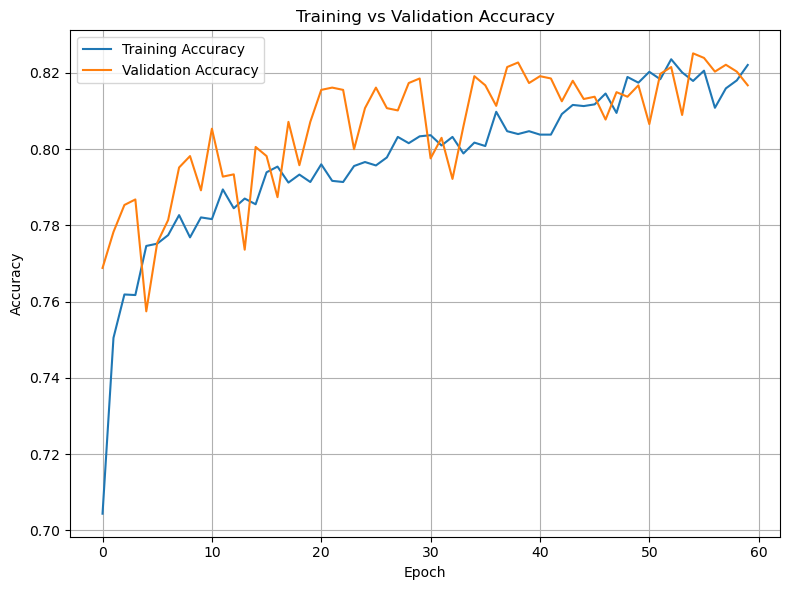

In [53]:
#accuracy compared to val acc over time?
import pickle
import matplotlib.pyplot as plt

# Load the saved training history
with open('/Users/elianafreedman/Desktop/cropped cmmd/resnet_training_history.pkl', 'rb') as f:
    history = pickle.load(f)

# Plot training vs validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig('/Users/elianafreedman/Desktop/cropped cmmd/accuracy_v_val_accuracy_plot.png')
plt.show()


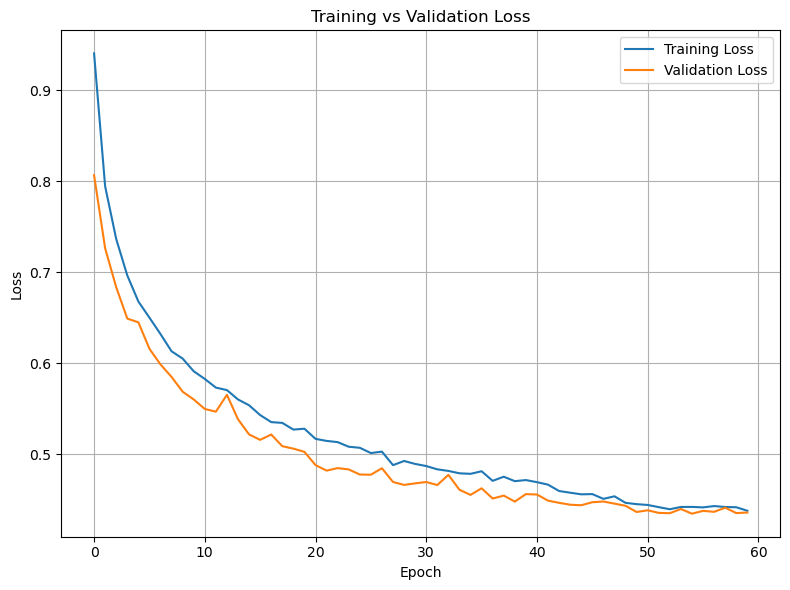

In [54]:
plt.figure(figsize=(8, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig('/Users/elianafreedman/Desktop/cropped cmmd/loss_v_val_loss_plot.png')
plt.show()
